# Кластеризация & метрики качества

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

### Данные

в sklearn.datasets есть разные наборы данных, можно выбрать другие

In [3]:
from sklearn.datasets import make_moons

In [4]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

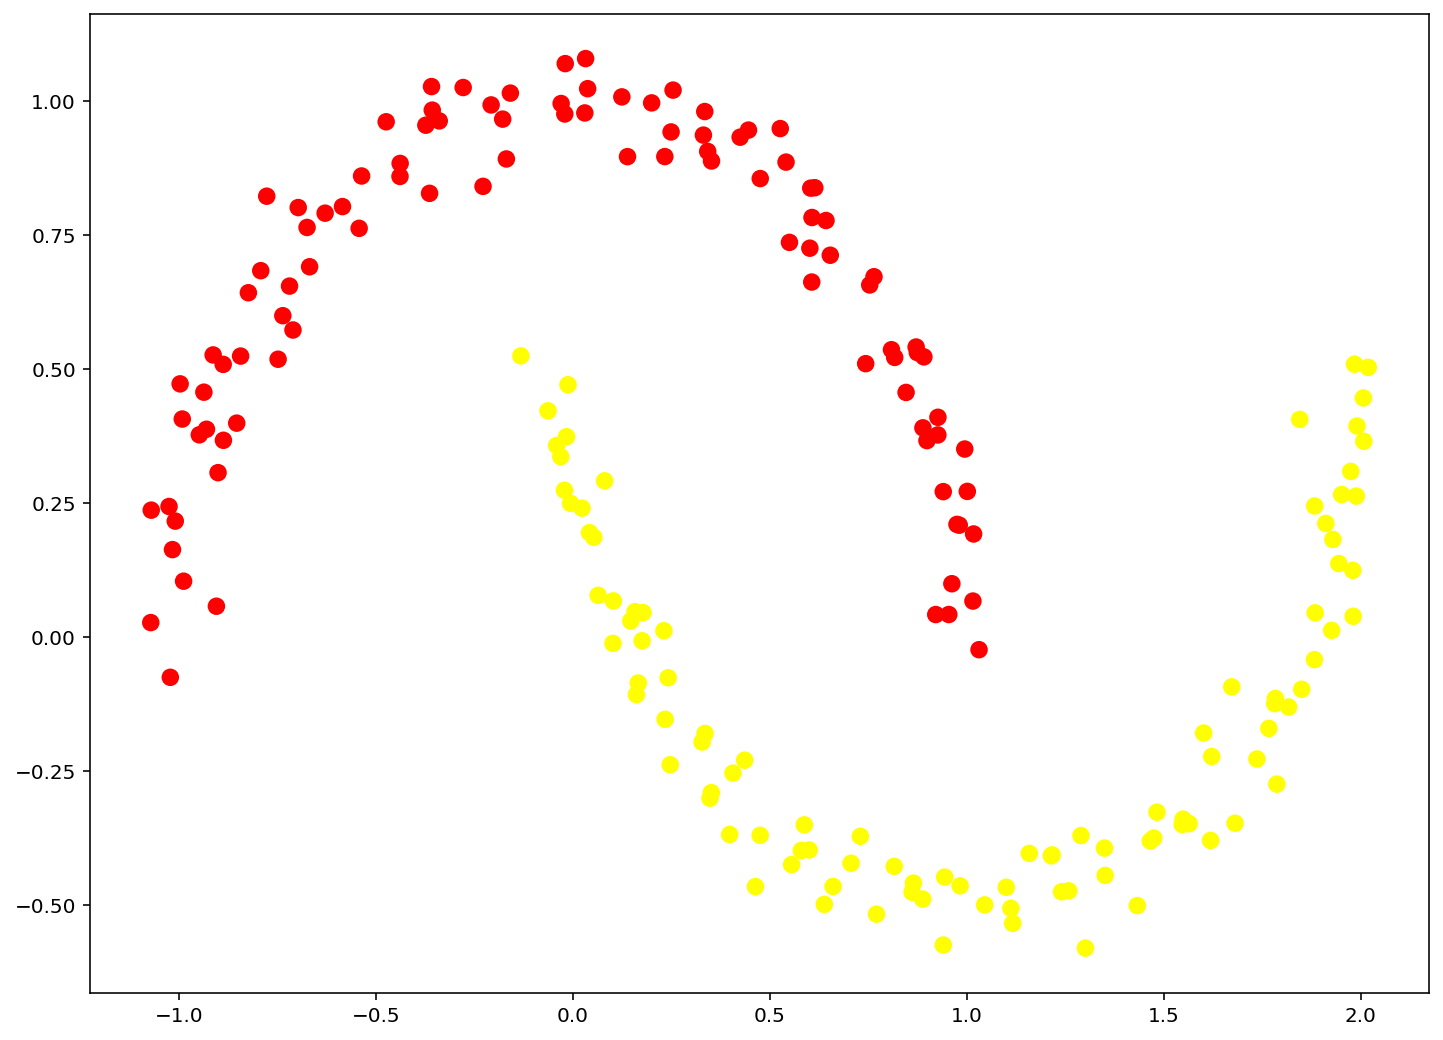

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=60)

приведём данные по обеим осям к нормальному распределению

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()

In [8]:
X_scaled = scaler.fit_transform(X)

форма осталась, но диапазоны выровнялись:

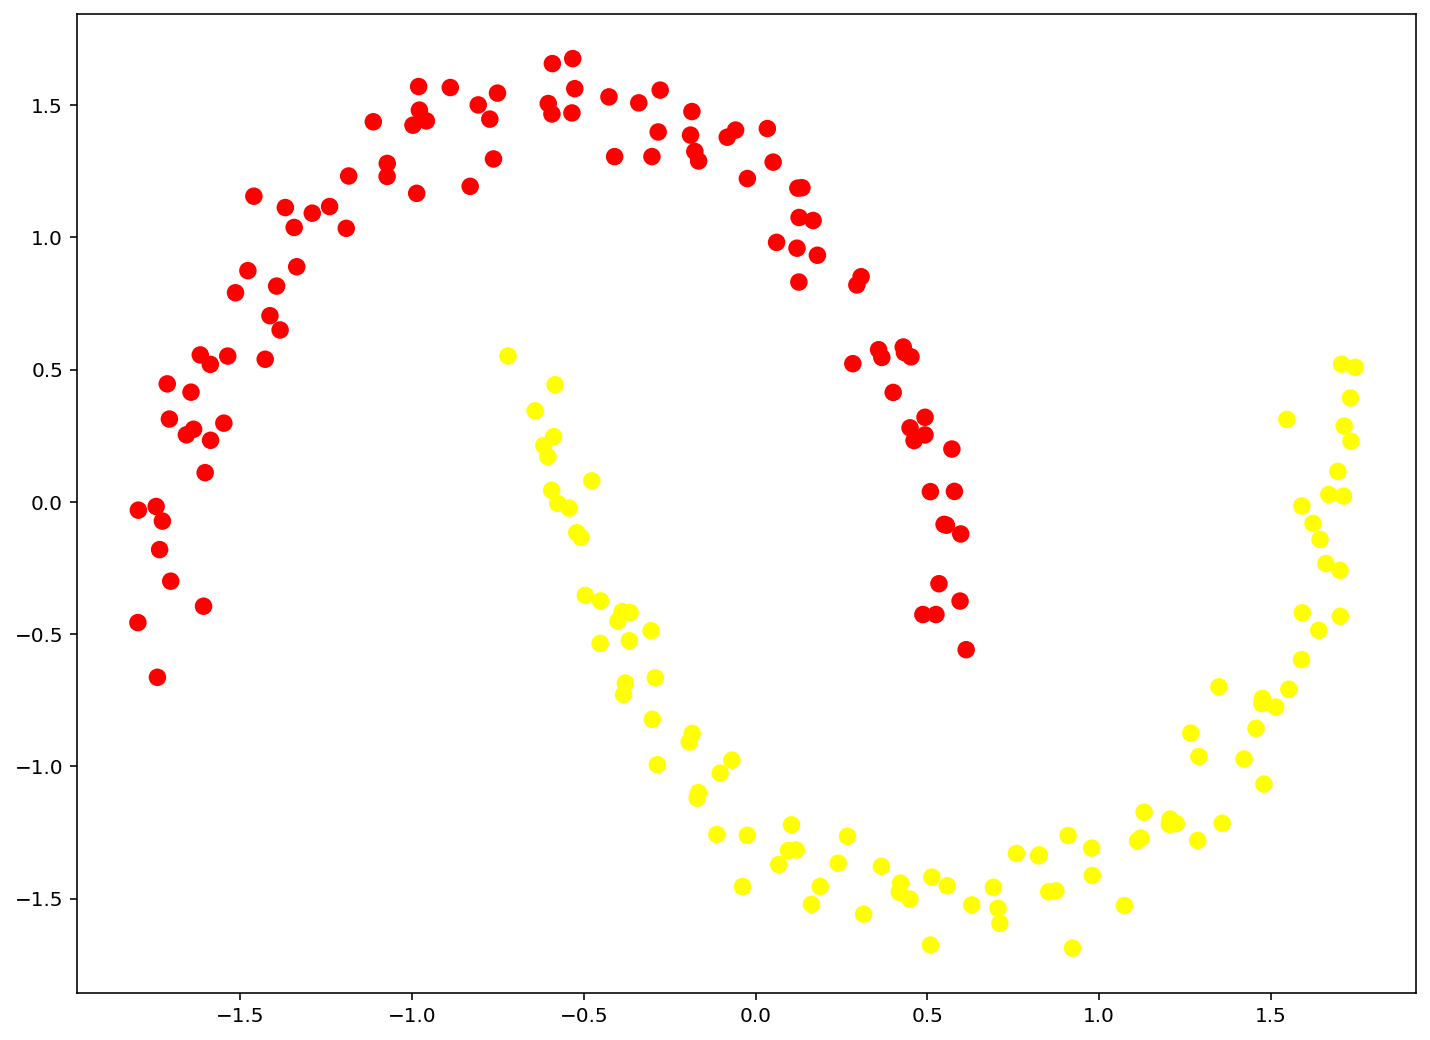

In [9]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='autumn', s=60)

### Кластеризация

теперь кластеризуем с помощью различных методов

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [11]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=2),
    AgglomerativeClustering(n_clusters=2),
    DBSCAN(),
]

сделаем случайное предсказание

In [12]:
clusters_random = np.random.randint(low=0, high=2, size=len(X))

и функцию-заготовку, которая считает 2 метрики качества и генерирует заголовки для графиков

In [13]:
def get_descr(algo_name, y, y_pred, X):
    return "{}\nARI {:.2f}\nSilhouette {:.2f}".format(
        algo_name,
        adjusted_rand_score(y, y_pred),
        silhouette_score(X, y_pred)
    )

In [14]:
import warnings
warnings.filterwarnings('ignore')

проследите за ростом ARI и за падением Silhouette (хотя этот показатель по своему назначению тоже должен расти):

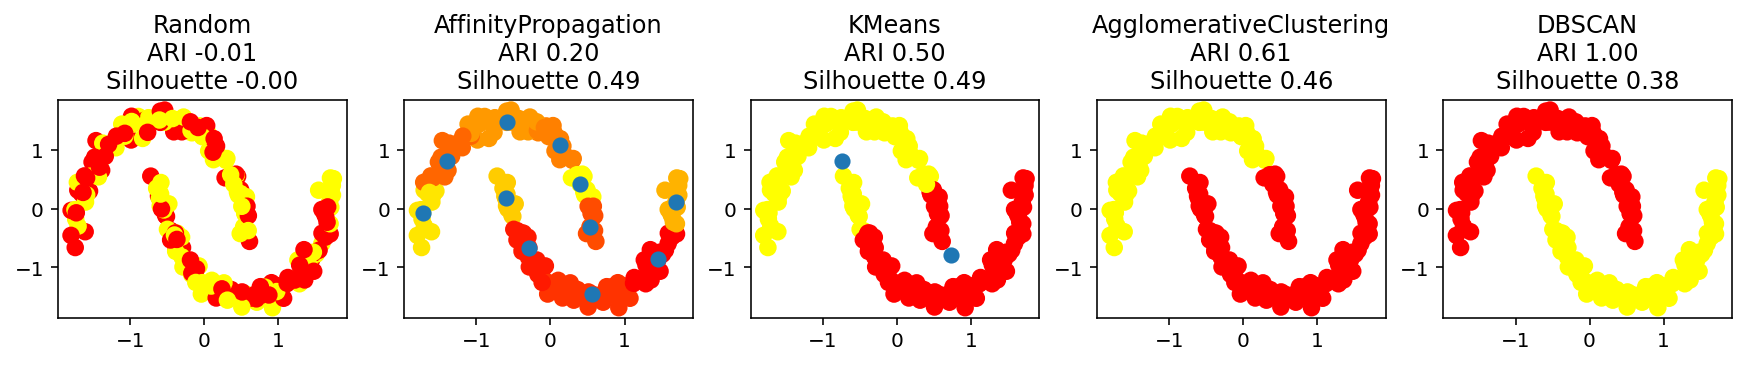

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=60)
axes[0].set_title(get_descr("Random", y, clusters_random, X_scaled))
for ax, algorithm in zip(axes[1:], algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))
    
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

# Подбор количества кластеров для KMeans

KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов. В обученном классификаторе это значение находится в поле inertia_

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [16]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

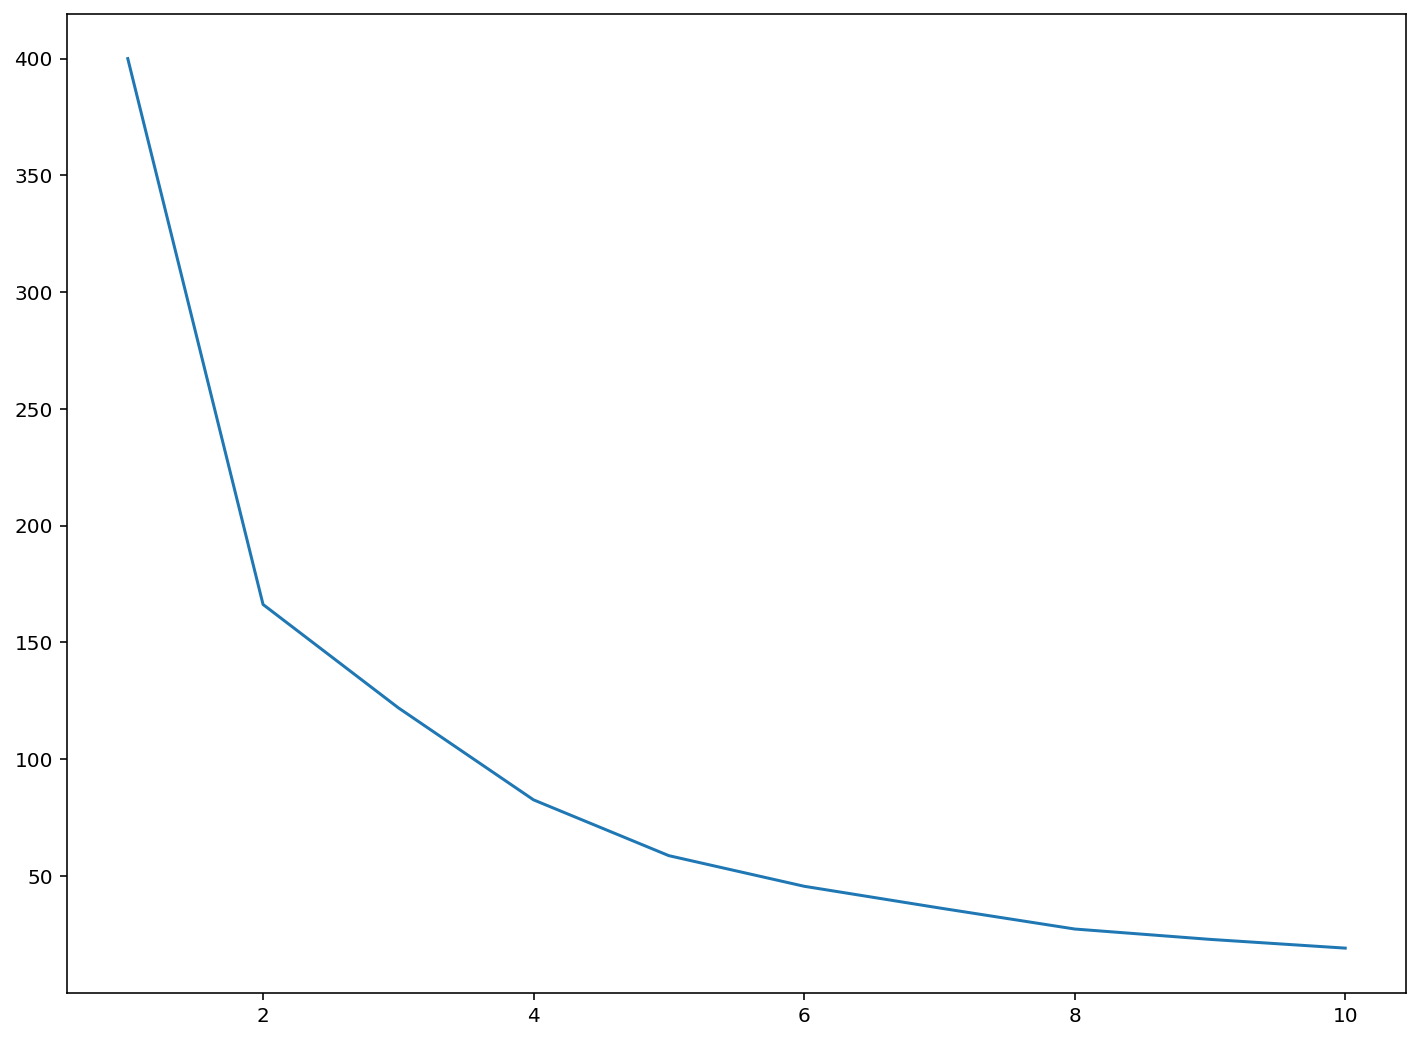

In [17]:
plt.plot(ks, k_inertia)

Как подобрать оптимальное значение? Будем на каждом шаге смотреть изменение inertia, и в тот момент, когда оно резко замедлится (относительно предыдущего изменения) мы и остановимся

Для начала считаем сами изменения

$${inertia_{k+1}-inertia_{k}}$$

In [18]:
diff = np.diff(k_inertia)

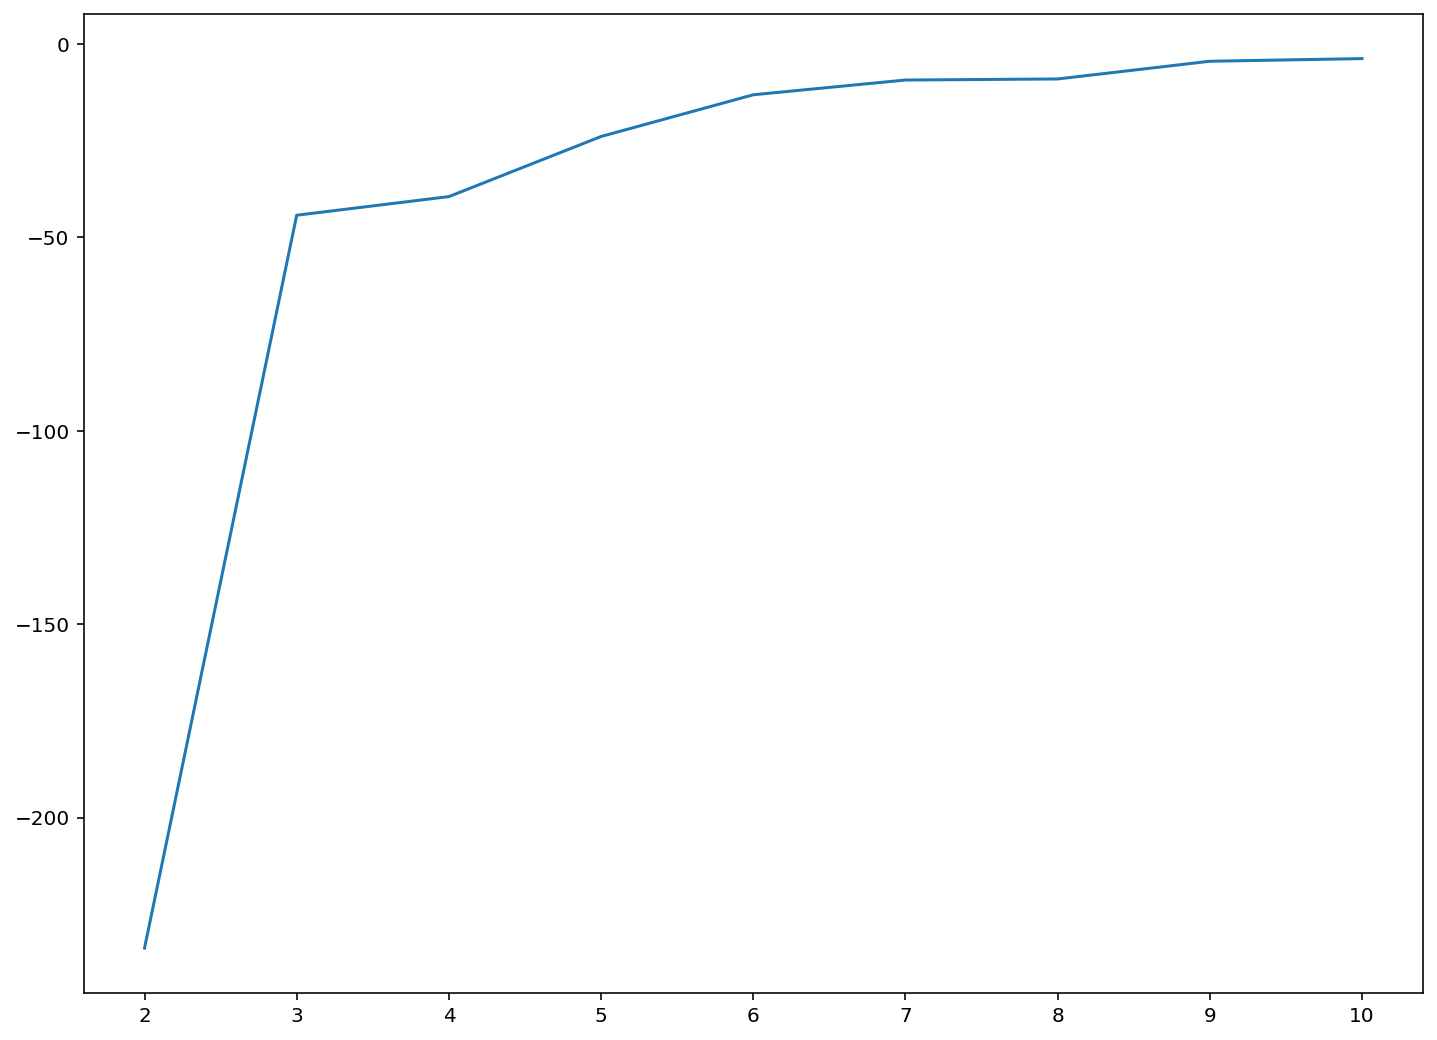

In [19]:
plt.plot(ks[1:], diff)

Теперь можно найти оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [20]:
diff_r = diff[1:] / diff[:-1]

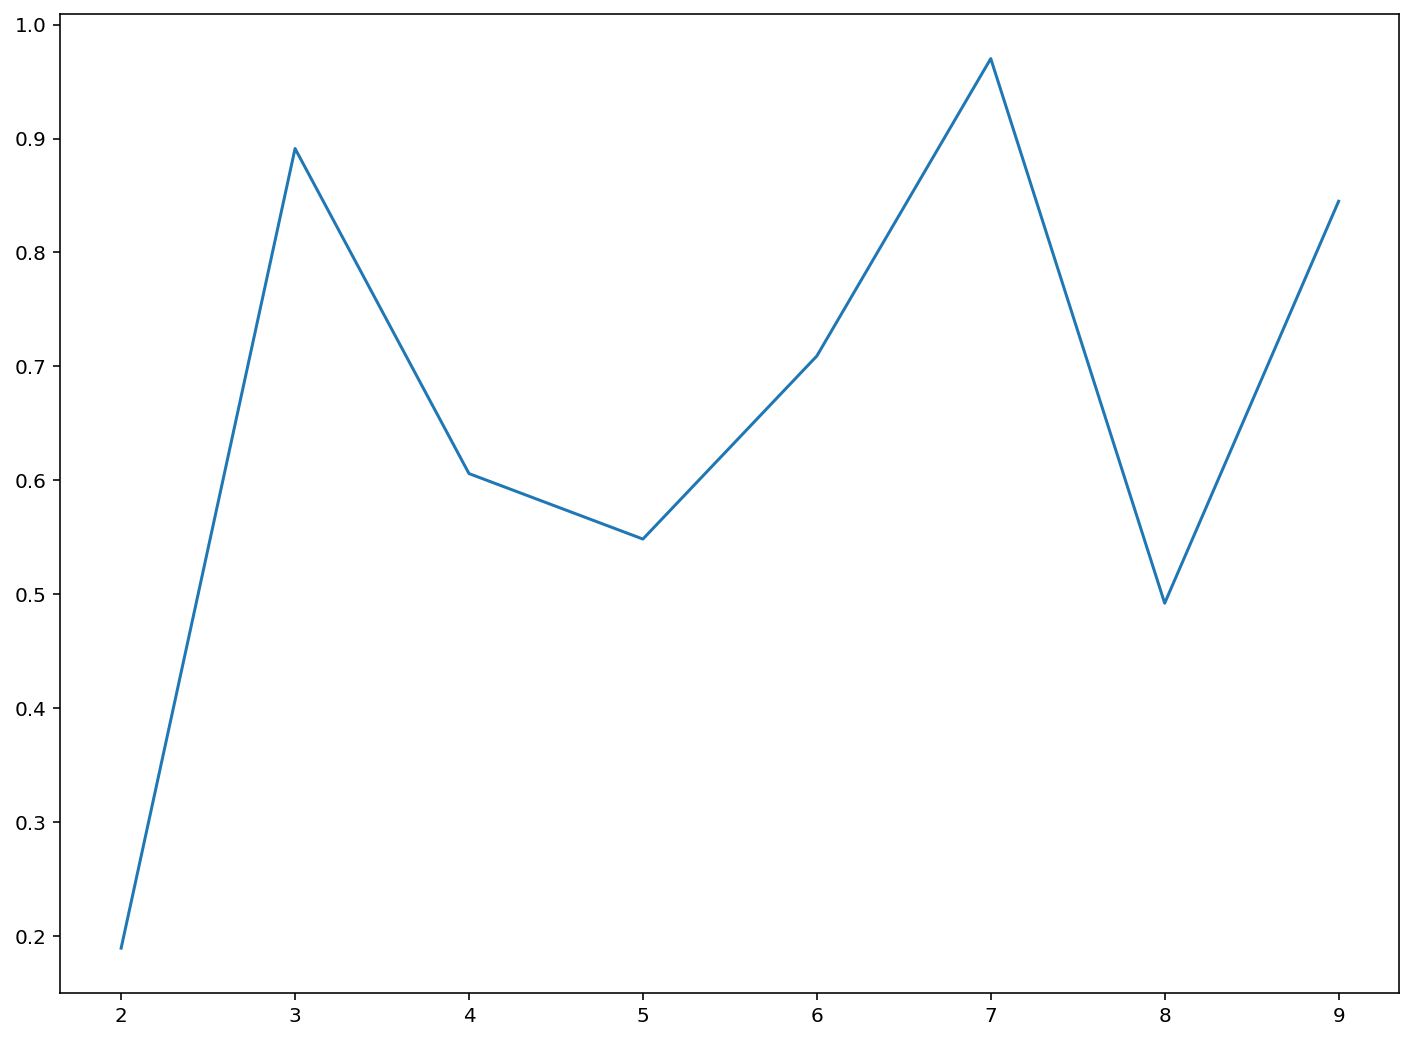

In [21]:
plt.plot(ks[1:-1], diff_r)

In [22]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

### Дендограмма

In [23]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data



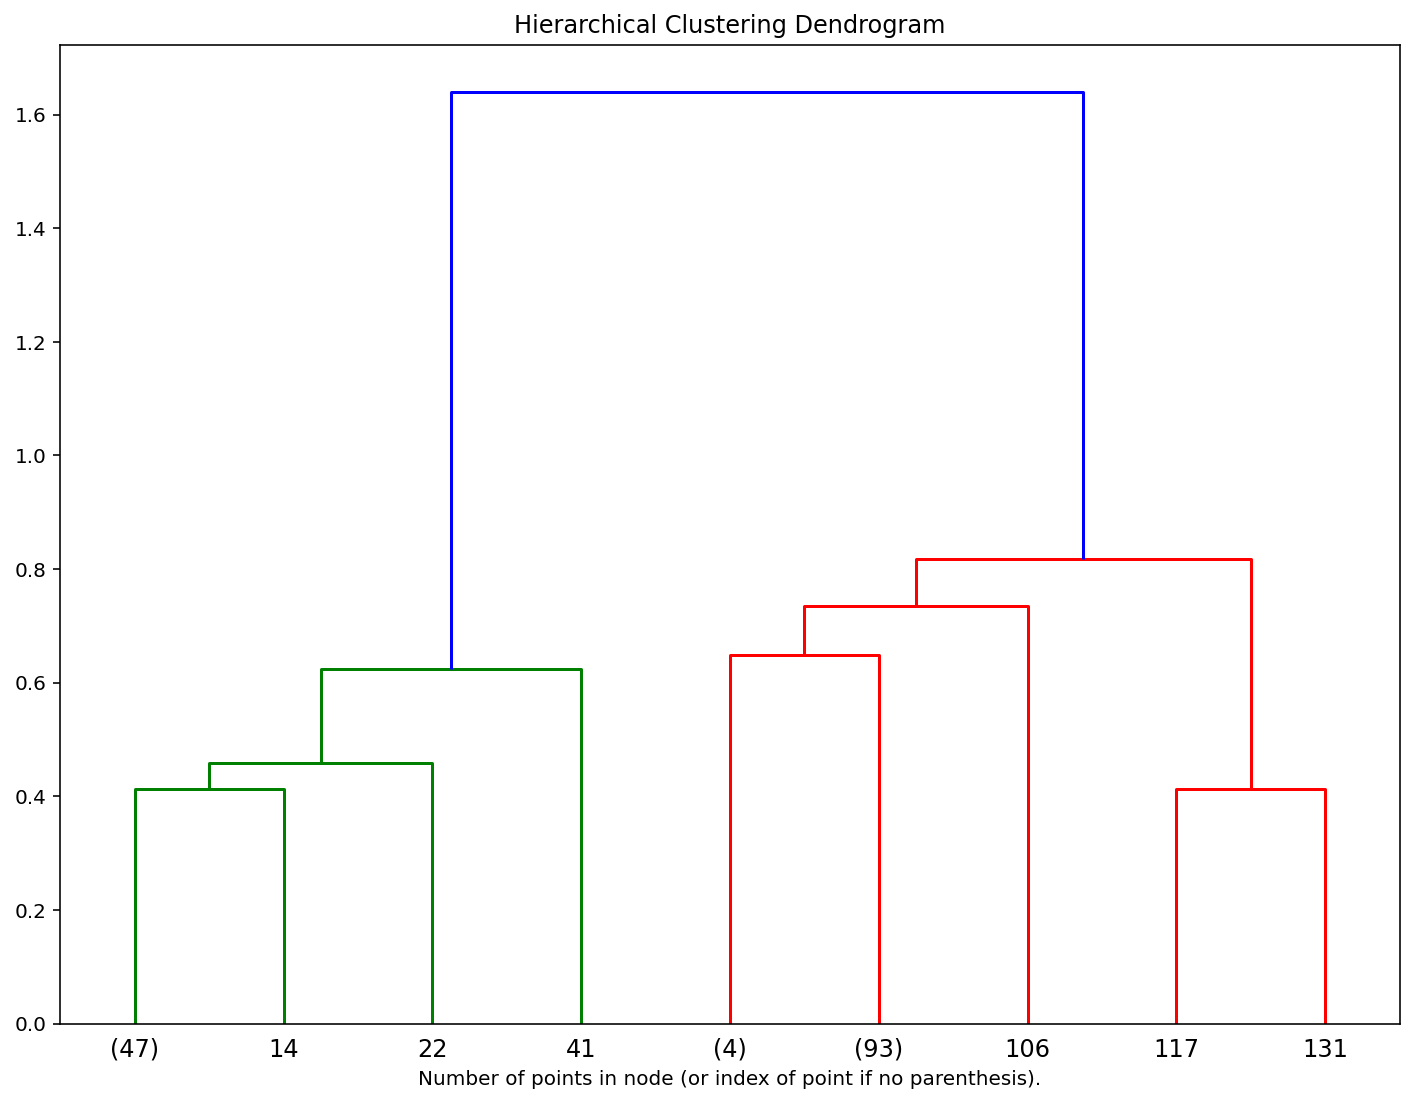

In [24]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

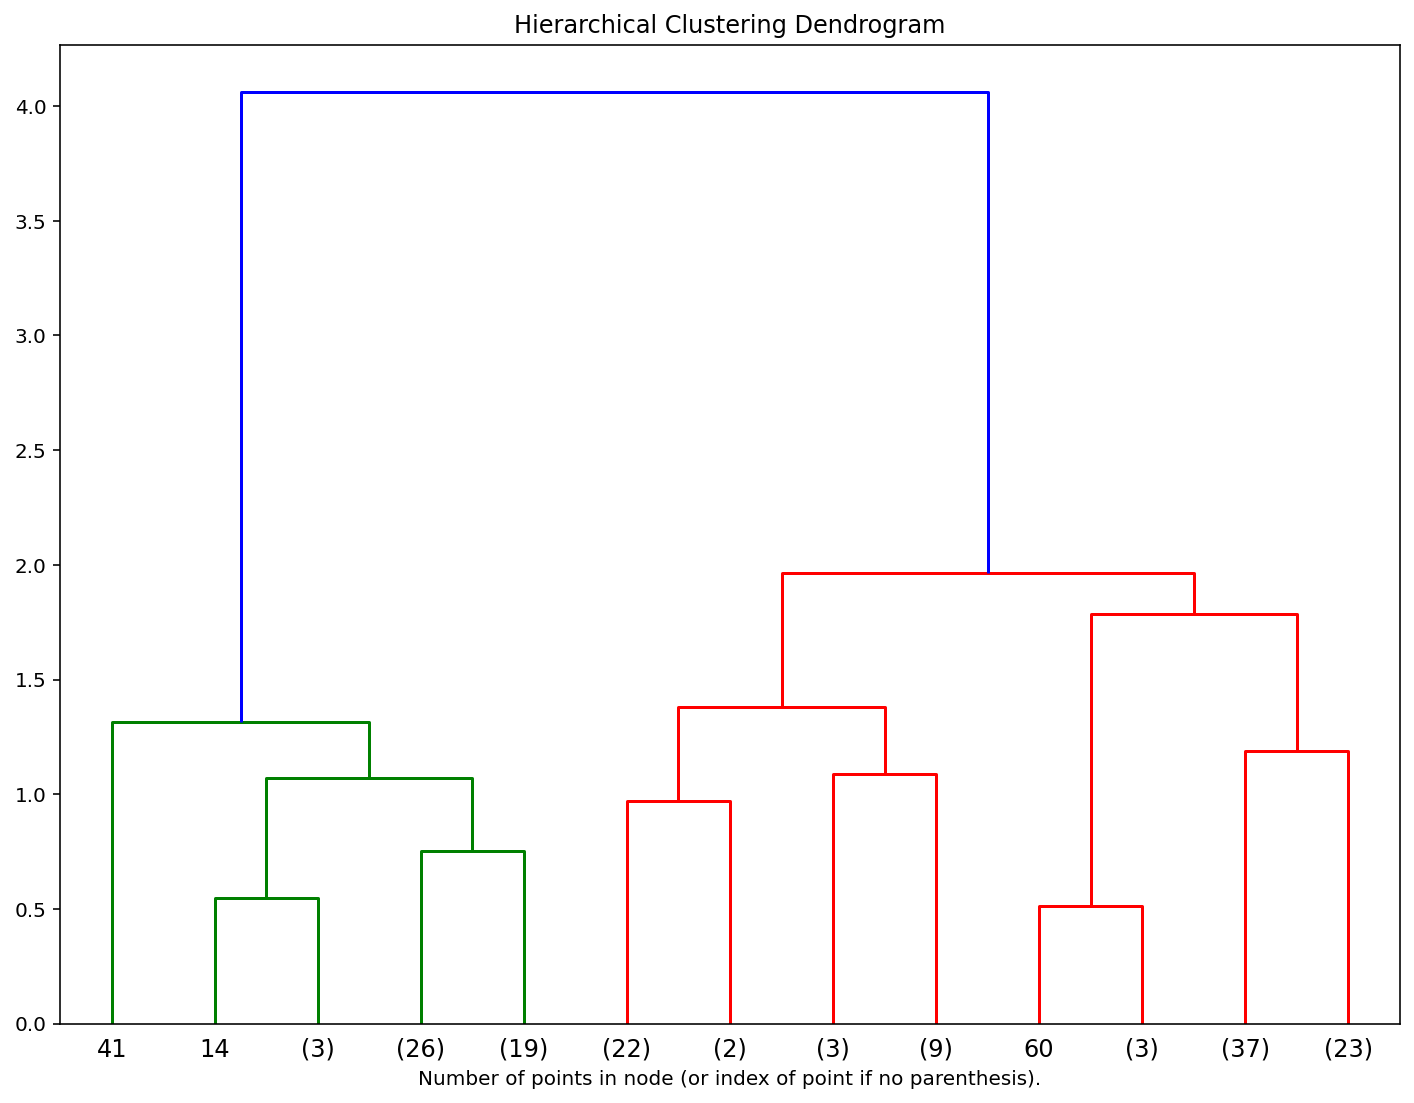

In [25]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

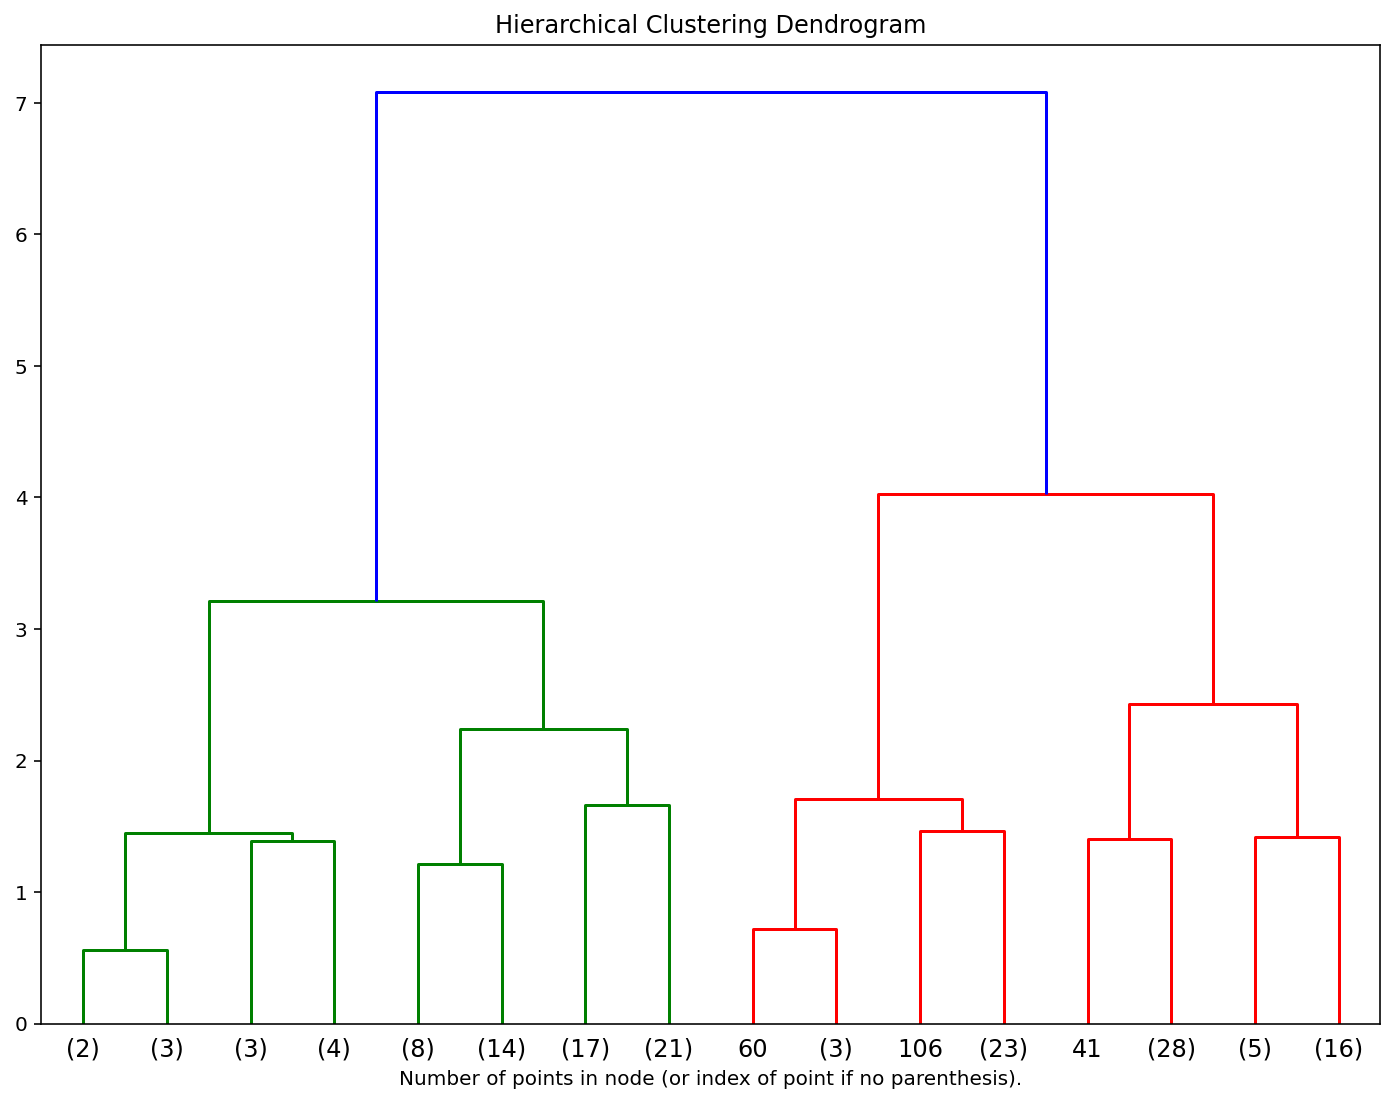

In [26]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

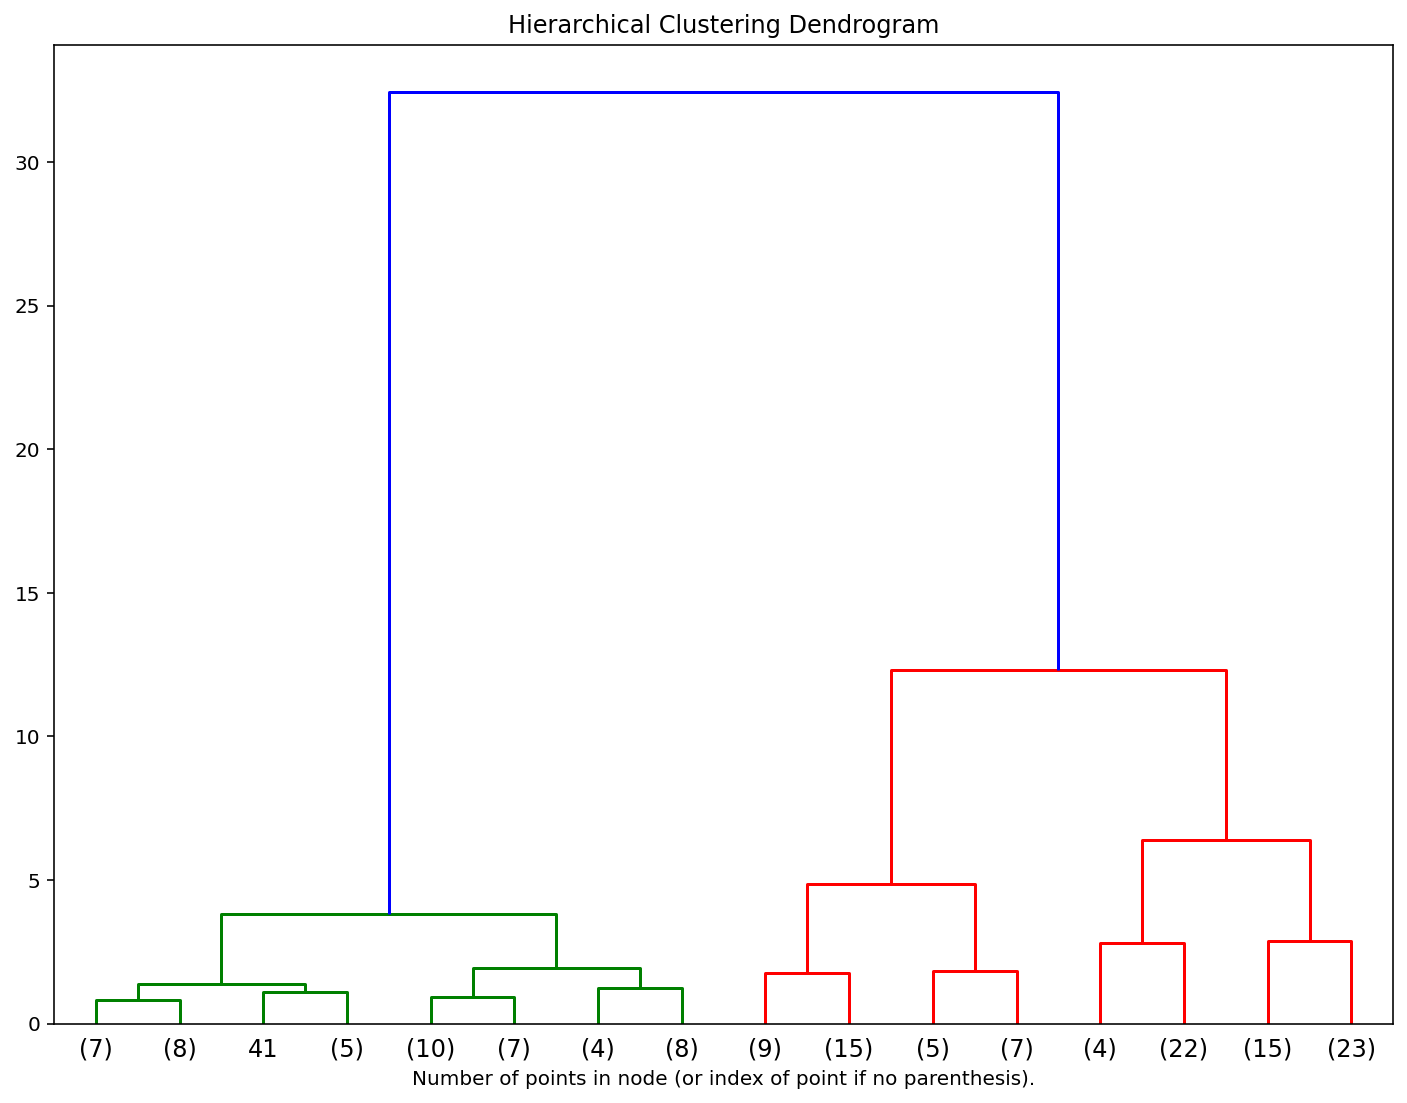

In [27]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [28]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

x = np.zeros((150,2))
np.random.seed(seed=42)
x[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
x[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)
x[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
x[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)
x[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
x[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

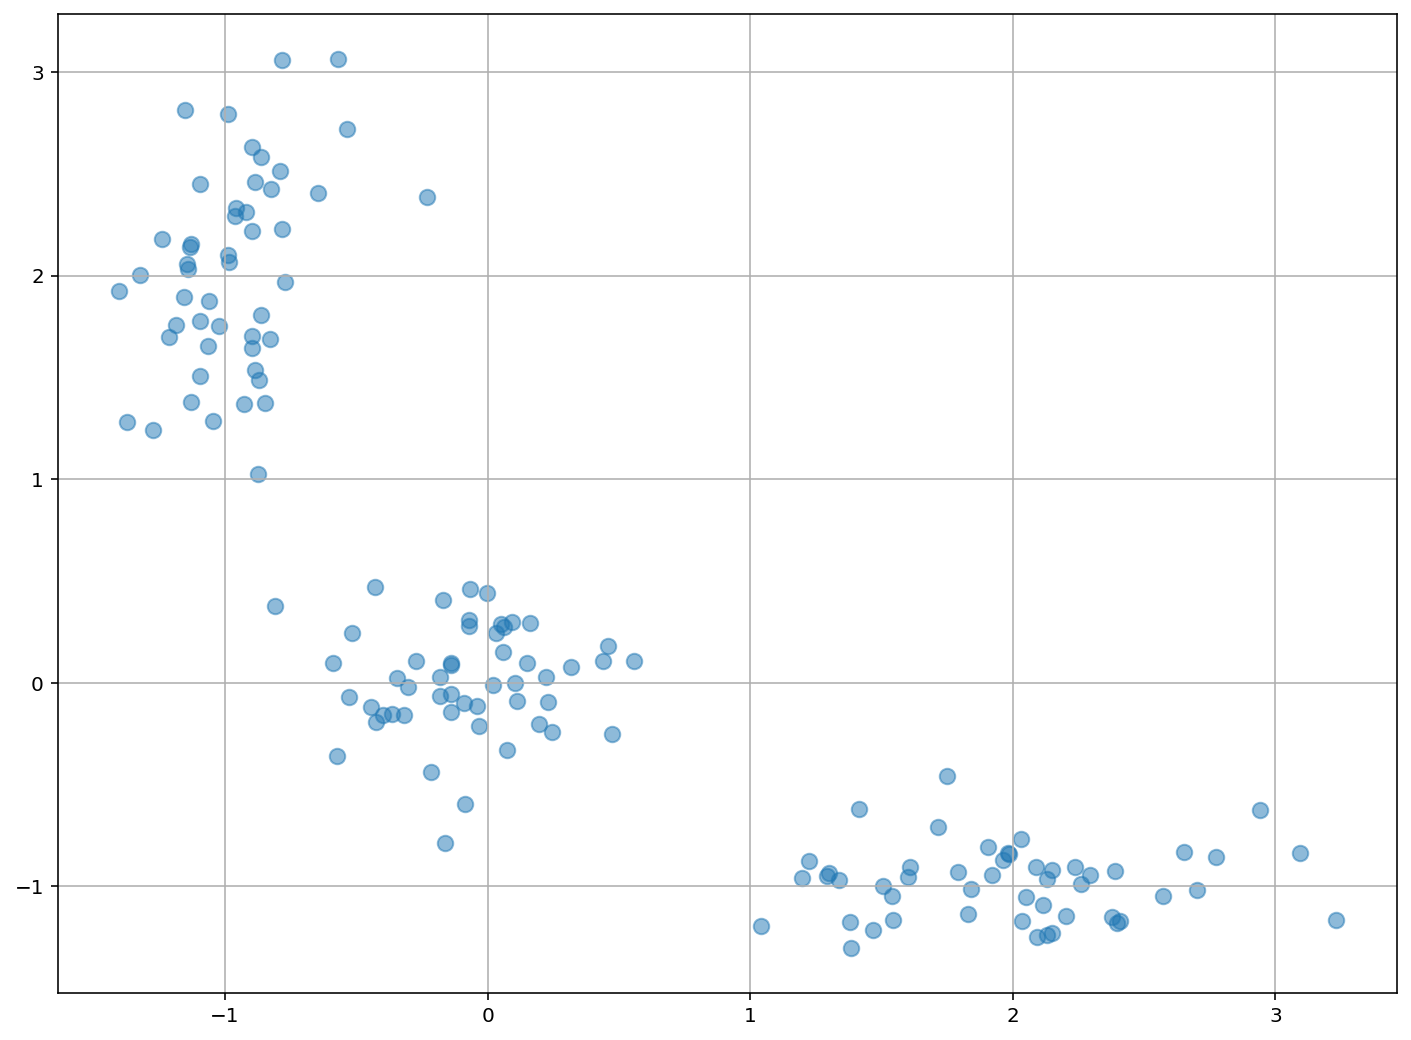

In [29]:
plt.scatter(x[:,0],x[:,1], s=60, alpha=0.5)
plt.grid()

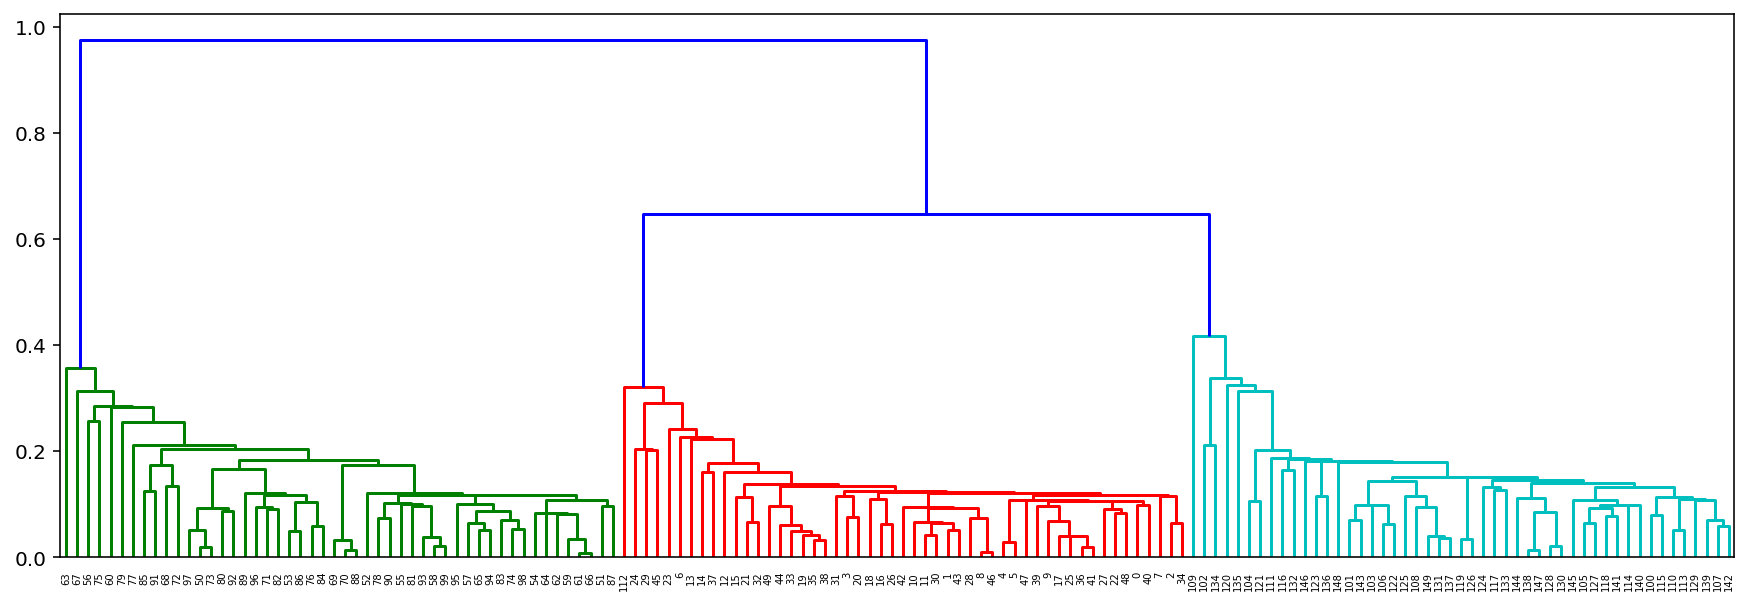

In [30]:
distance_mat = pdist(x)

Z= hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z,color_threshold=0.5)

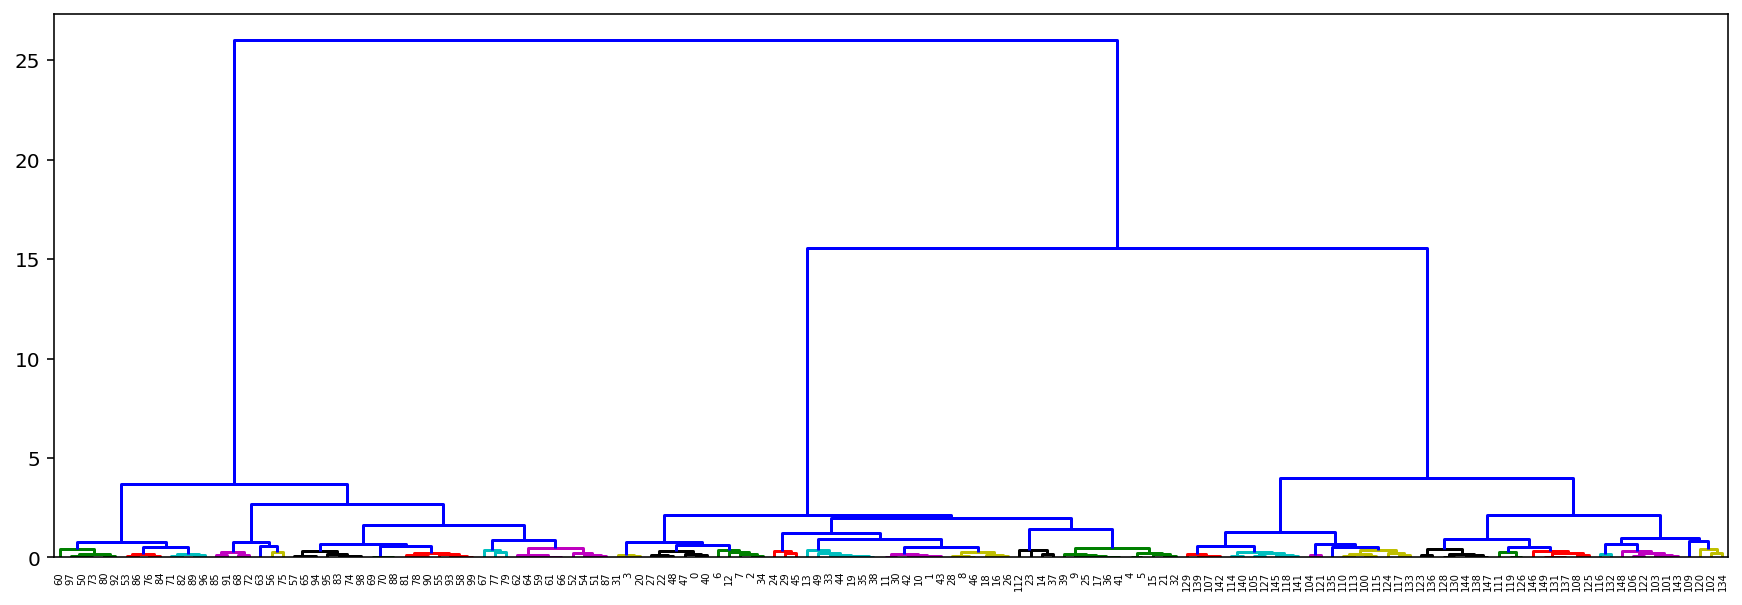

In [31]:
Z= hierarchy.linkage(distance_mat, 'ward')
plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z,color_threshold=0.5)

## DBSCAN

In [36]:
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=0)

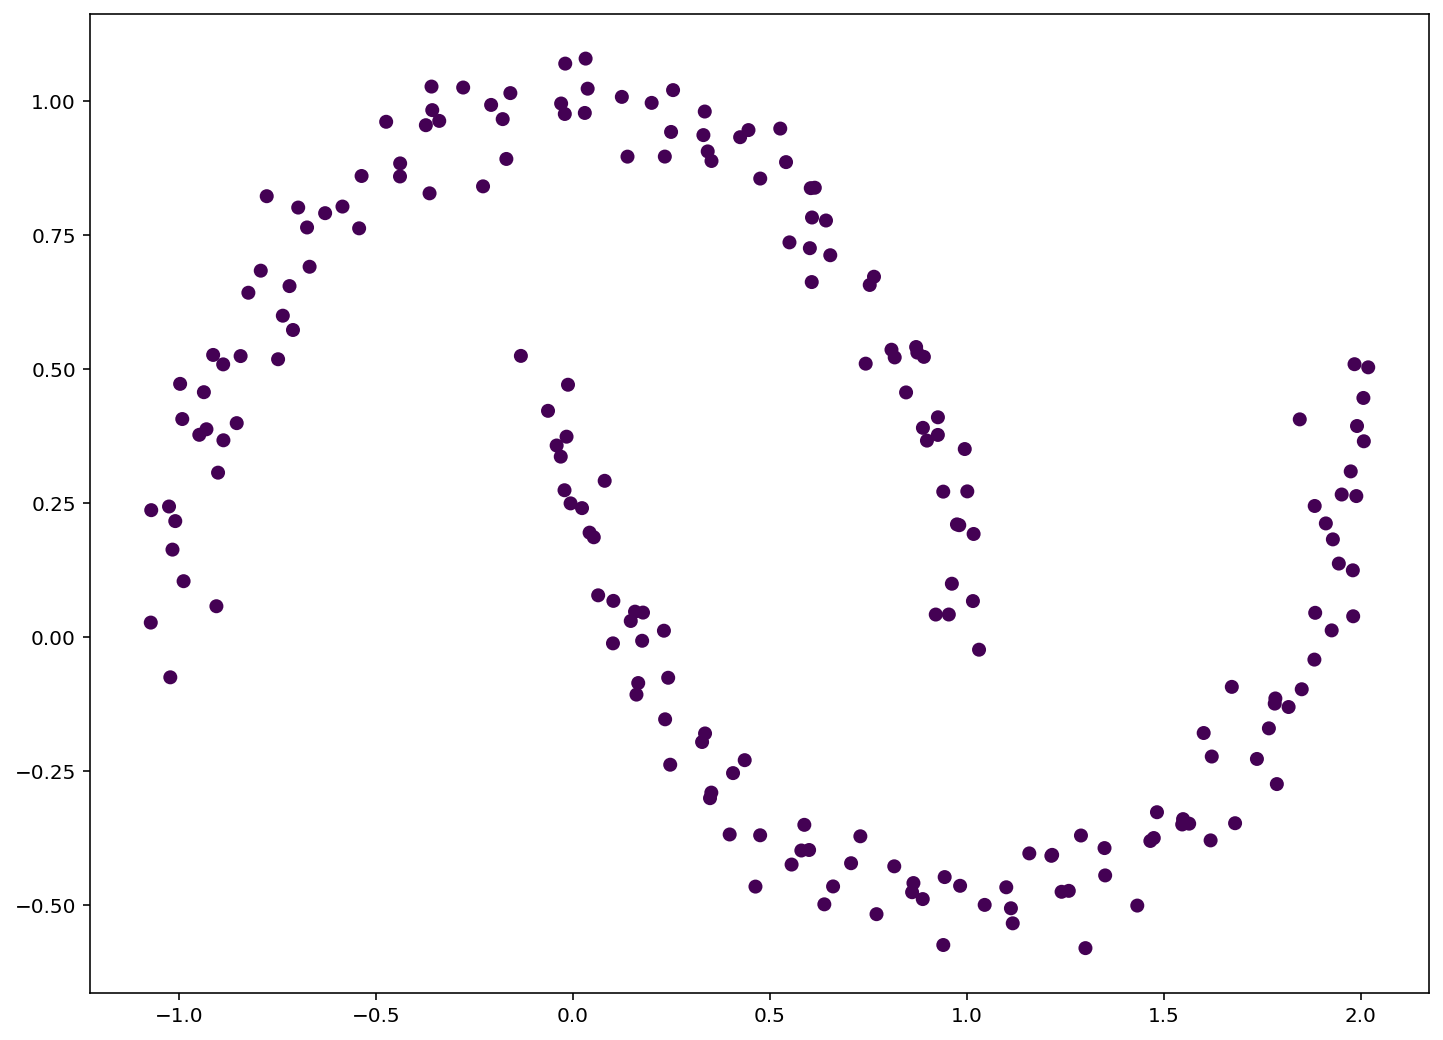

In [37]:
scan_moons = DBSCAN() # если запустить метод без указания eps то все точки в один кластер
y_moons = scan_moons.fit_predict(X_moons)
plt.figure(figsize=(12,9))
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
plt.show()

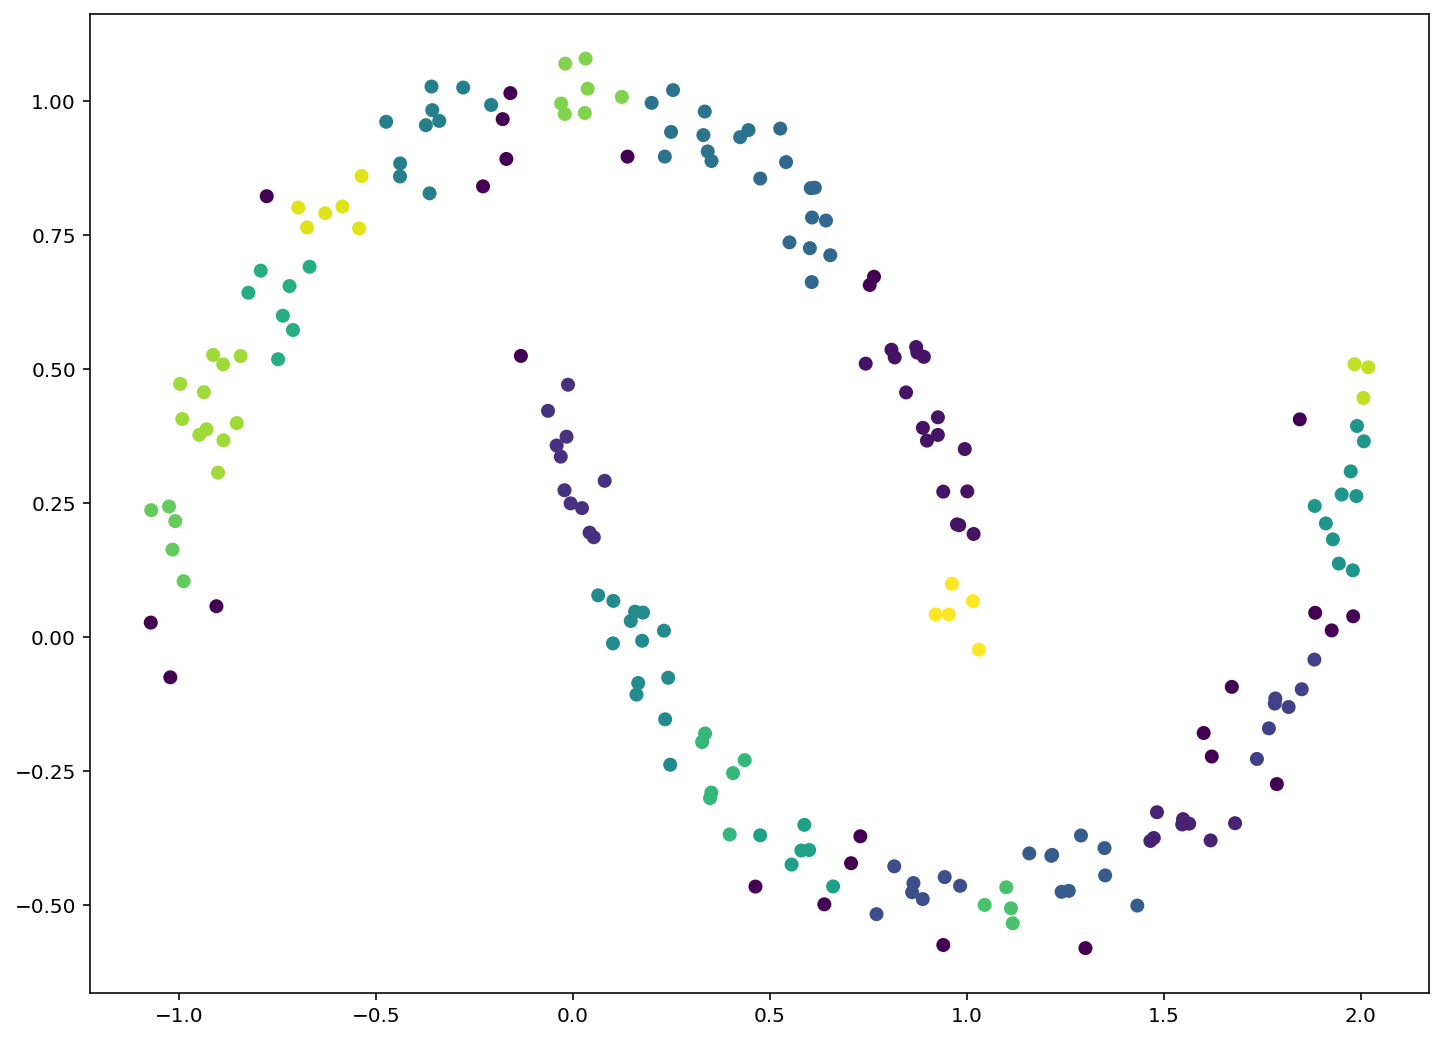

In [38]:
scan_moons = DBSCAN(eps=0.1)# указываем eps
y_moons = scan_moons.fit_predict(X_moons)
plt.figure(figsize=(12,9))
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
plt.show()

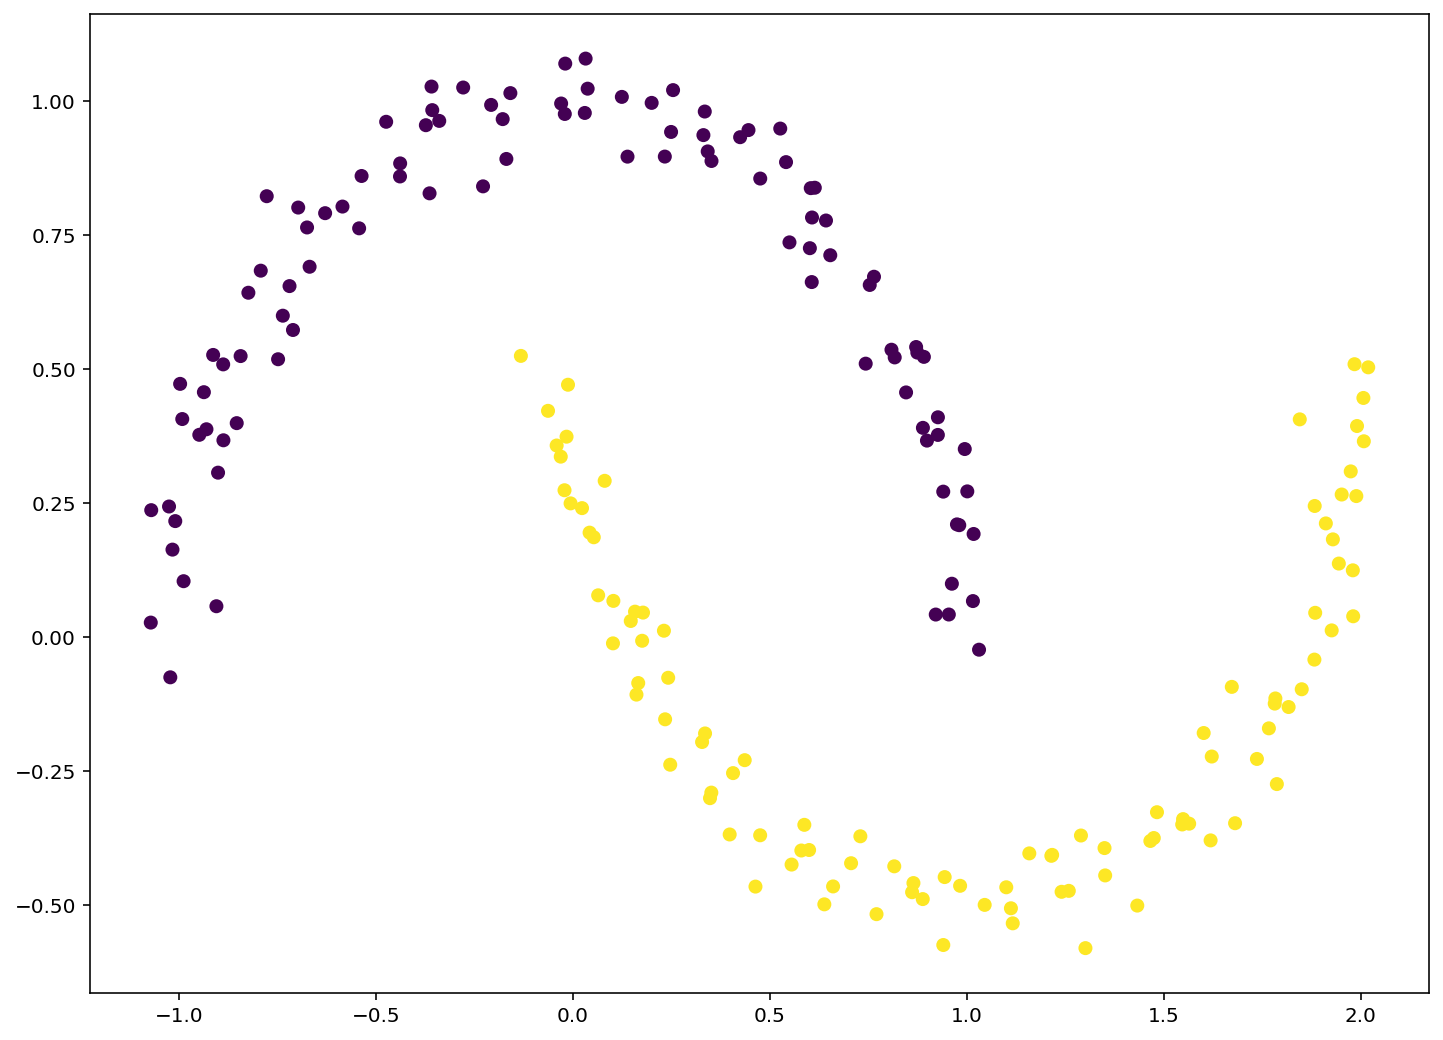

In [39]:
scan_moons = DBSCAN(eps=0.25) # путем подбора правильного eps приходим к верному кол-ву кластеров
y_moons = scan_moons.fit_predict(X_moons)
plt.figure(figsize=(12,9))
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
plt.show()